In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os


# Load data

In [ ]:
df_all = pd.read_csv('eua_price_data.csv', thousands=',') 
df_all['Date'] = pd.to_datetime(df_all['Date'], format='%Y-%m-%d')  
df_all.set_index('Date', inplace = True).sort_index(ascending = True)
df_all = df_all[(df_all['Date'] > pd.to_datetime('2020-12-11'))].reset_index(drop=True)

# Preprocessing & train/test data split

In [3]:
from script.curate_training_test_data import  curate_training_test_data_many

predictors_lst =['EUA','Oil', 'Coal','Power', 'GDP', 'S&P_clean', 'High_price', 'Low_price']
test_date = '2024-07-23' 

folder_name = "result_ml_sklearn"
modeltype = 'knn'
if os.path.isdir(folder_name) is not True:
    os.mkdir(folder_name)
sequence_length = 28
checkpoint_path = f"./{folder_name}/{modeltype}_ts_{sequence_length}.skl"

last_train_date = pd.to_datetime(test_date) - pd.to_timedelta(1, unit = 'day')
X_train, y_train, X_test, y_test, scaler = curate_training_test_data_many(
                                            df_all, 
                                            flatten=True,
                                            sequence_length_input=28,  # 입력 시퀀스 길이 (30일)
                                            sequence_length_out=28,    # 입력 시퀀스 길이 (30일)
                                            test_date=test_date,
                                            predictors_lst=predictors_lst,
                                            dtype = 'float32',
                                            is_test_split = True,
                                            )


In [4]:
import pickle
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

models = {
    'lr':LinearRegression() ,
    'ridge': Ridge(),
    'lasso': Lasso(),
    'dt':DecisionTreeRegressor(),
    'rf':RandomForestRegressor(),
    # 'gb':GradientBoostingRegressor(),
    'knn':KNeighborsRegressor()
}
# Define the hyperparameter search grid
param_grids = {
    'lr': {
    'fit_intercept': [True, False],
},
    'ridge': {
    'alpha': [0.1, 1, 10, 100],
    'fit_intercept': [True, False],
},
    'lasso':{
    'alpha': [0.1, 1, 10, 100],
    'fit_intercept': [True, False],
    'max_iter': [1000, 5000, 10000]
},
    'dt':
        {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 5, 7],
    'max_features': [None, 'sqrt']
},
    'rf':{
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10]
},
#     'gb':{
#     'n_estimators': [10, 50, 10],
#     'learning_rate': [0.1, 0.05, 0.01],
#     'max_depth': [3, 5, 10],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 5, 10]
# },
    
    'knn':{'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance'],
            'algorithm': ['ball_tree', 'kd_tree', 'brute']}
}

for key in models.keys():
    if os.path.isfile(f'best_mutistep_{key}_model.skl') == False:
        grid_search = GridSearchCV(models[key], param_grids[key], 
                                cv=3, 
                                scoring='neg_mean_squared_error',
                                )
        grid_search.fit(X_train, y_train)

        model = grid_search.best_estimator_
        model.fit(X_train, y_train)
        with open(f'best_mutistep_{key}_model.skl', 'wb') as f:
            pickle.dump(model, f)
            
    print(f'... {key} is done.')

... lr is done.
... ridge is done.
... lasso is done.
... dt is done.
... rf is done.
... knn is done.


c:\100_Research\eua_prediction\script\post_processing.py:361: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize = figsize)


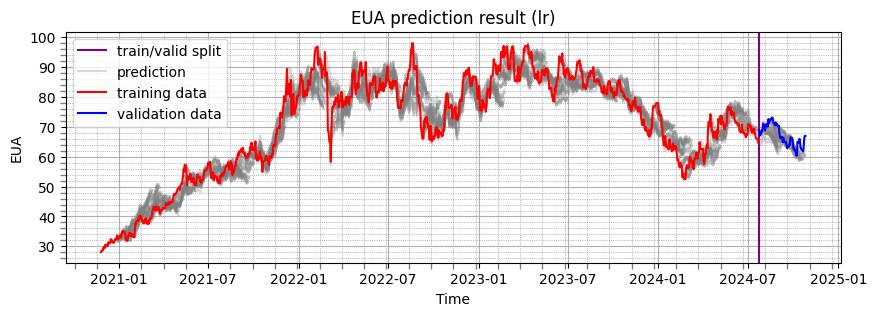

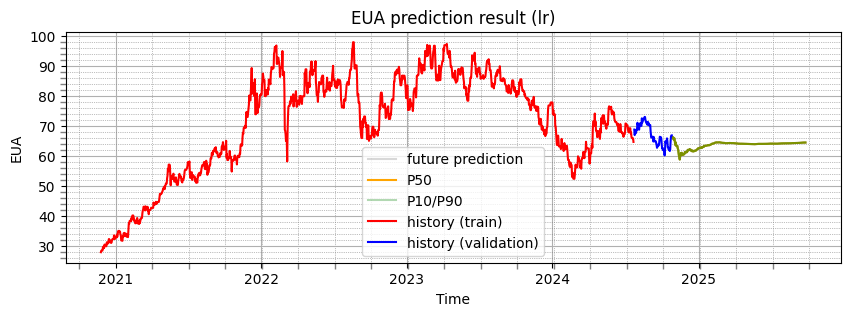

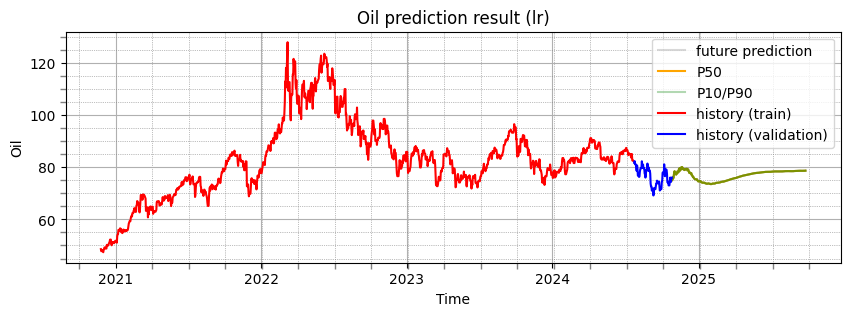

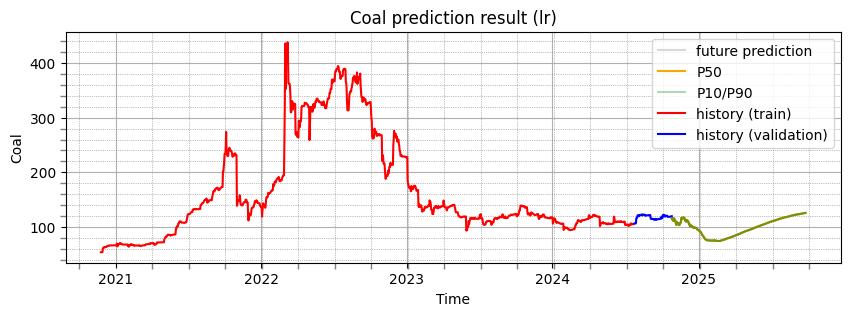

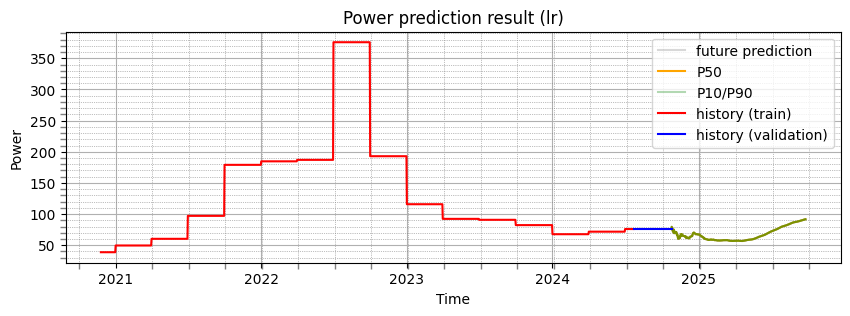

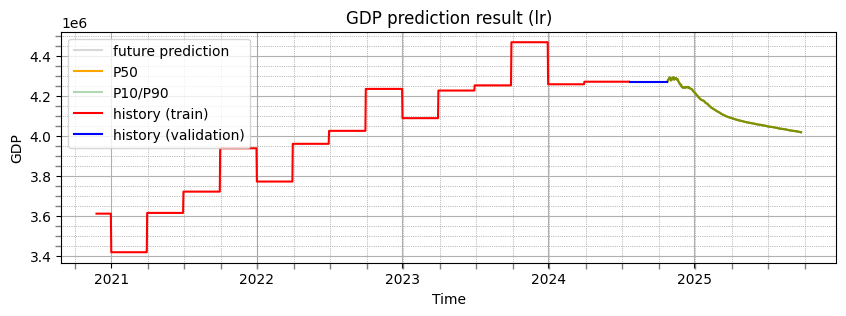

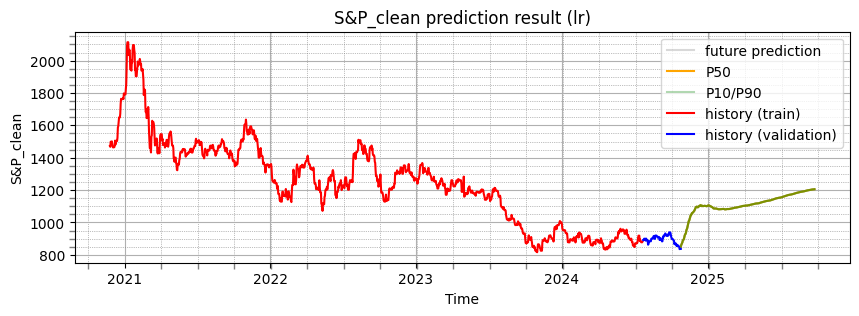

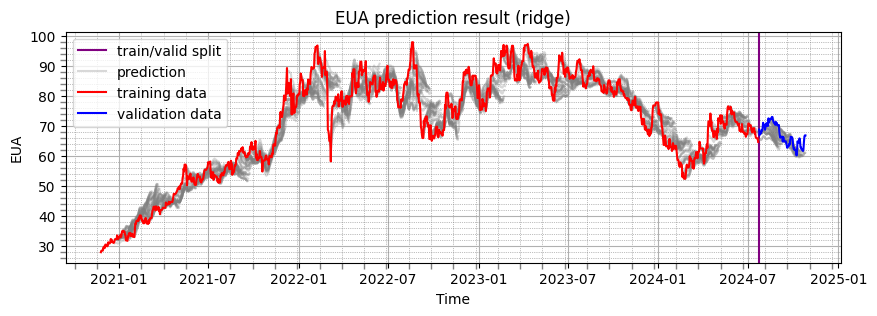

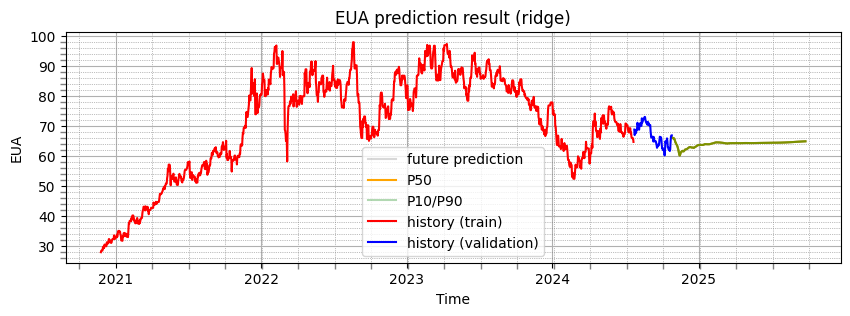

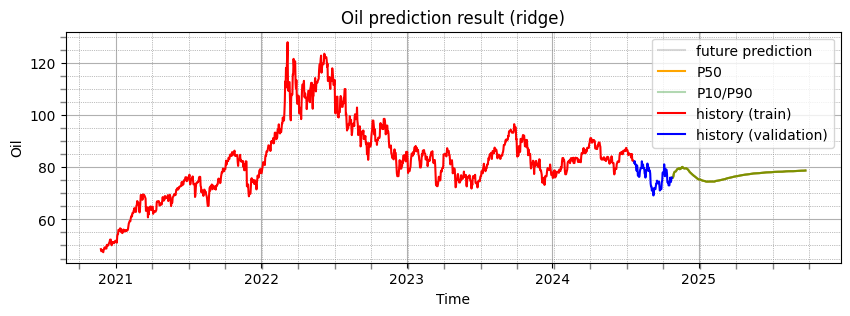

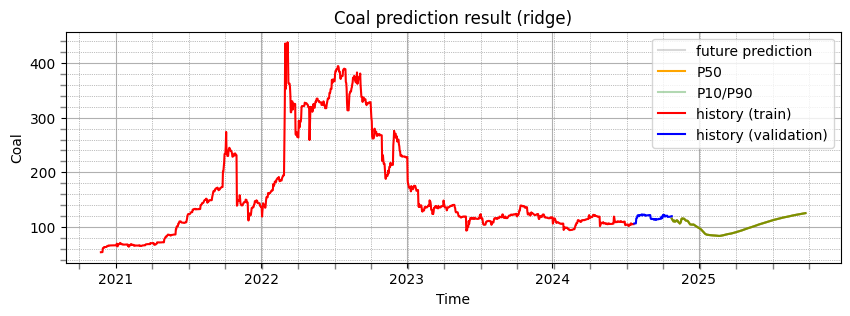

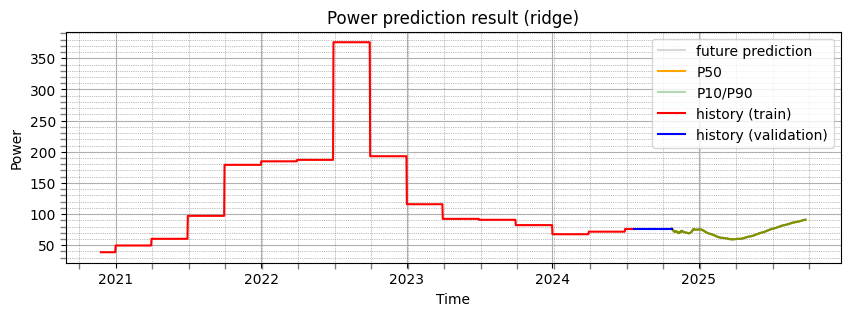

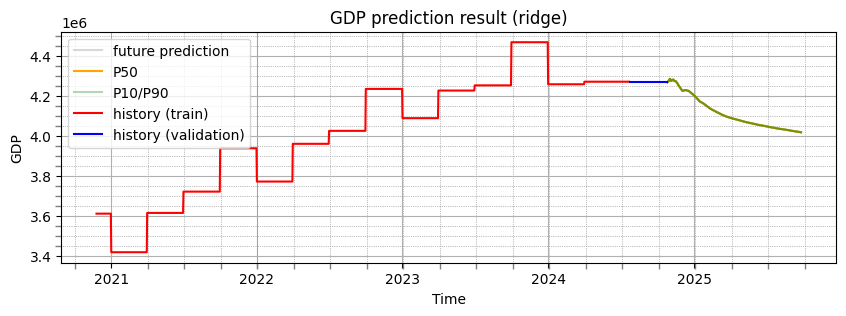

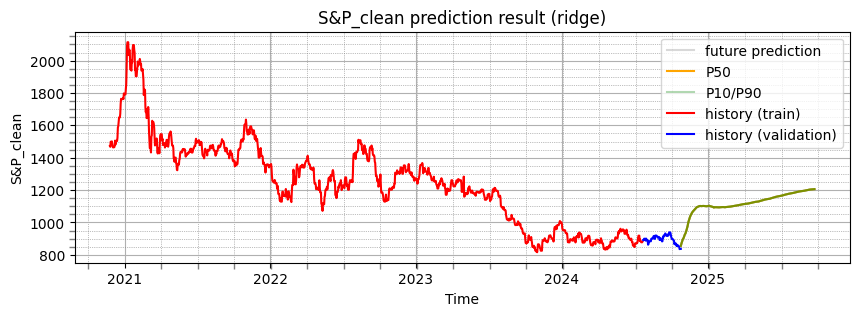

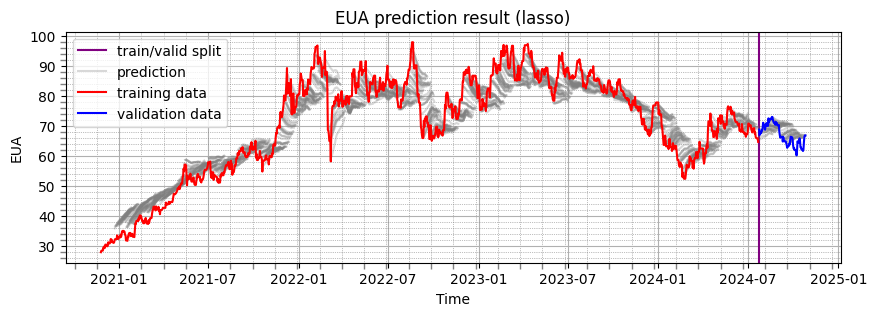

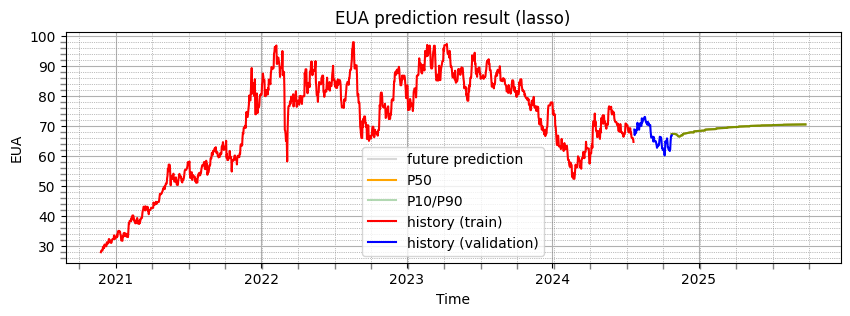

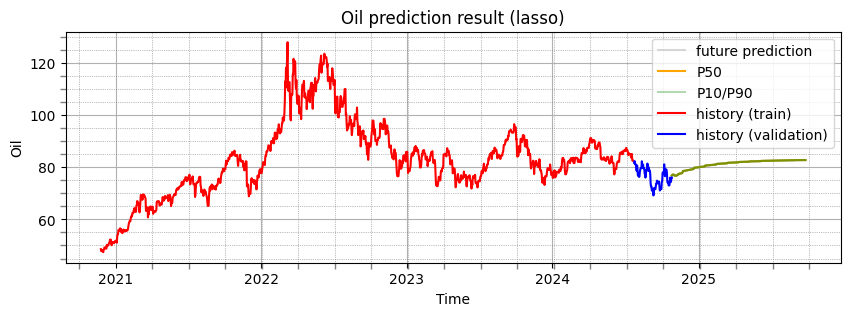

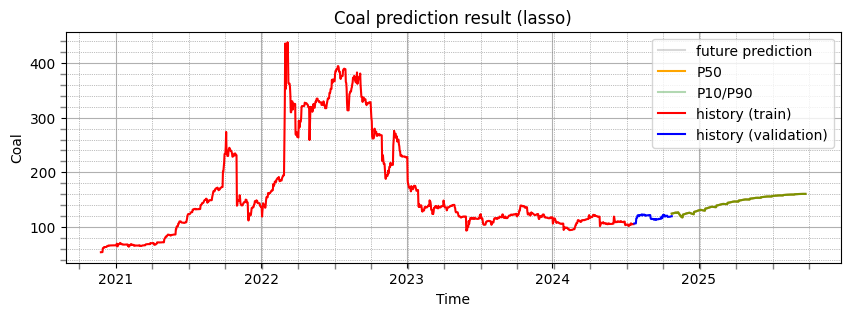

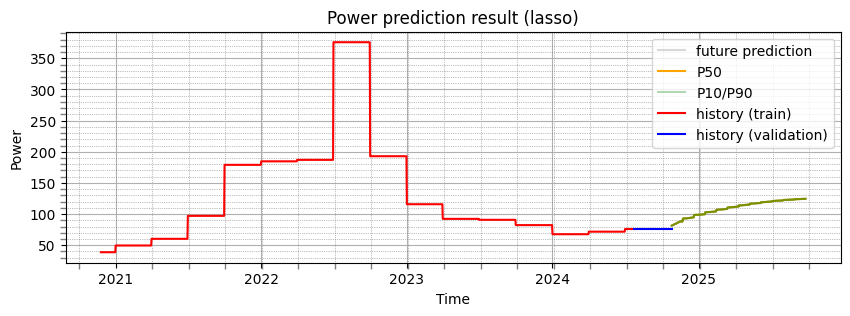

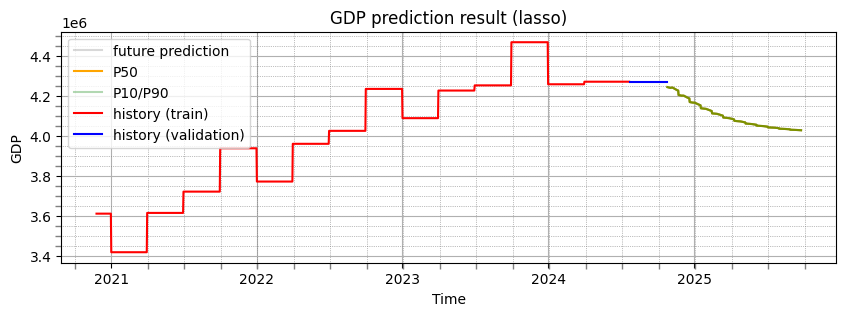

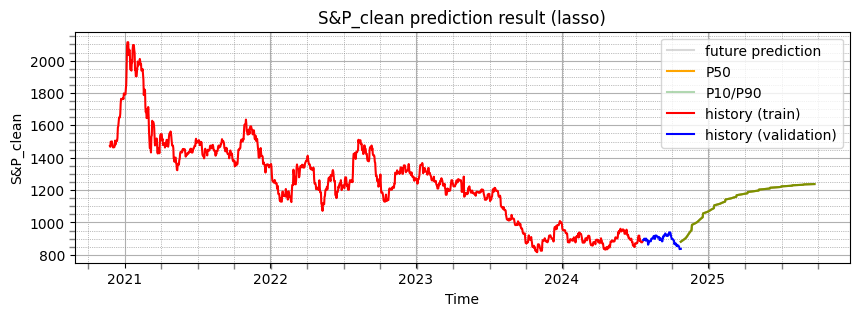

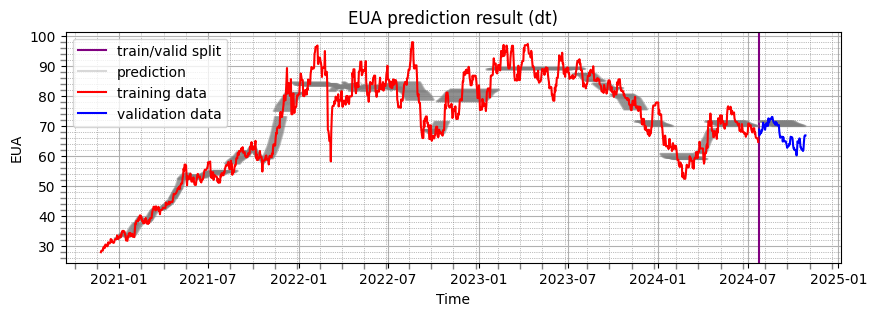

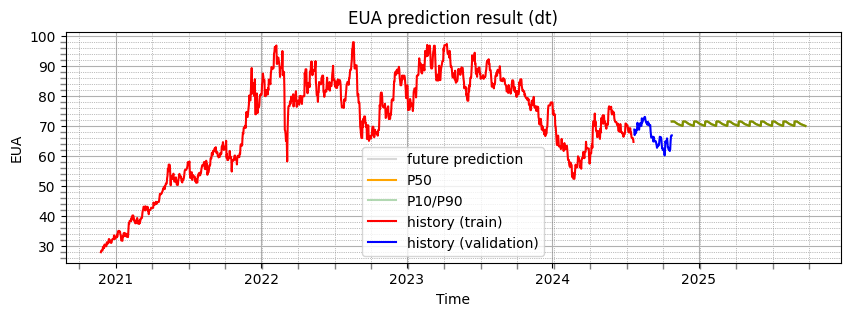

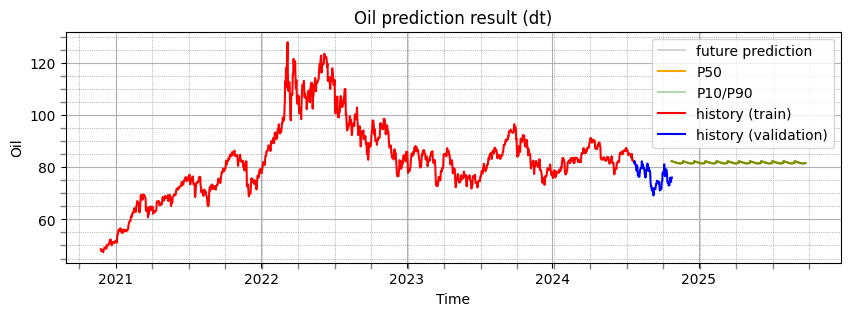

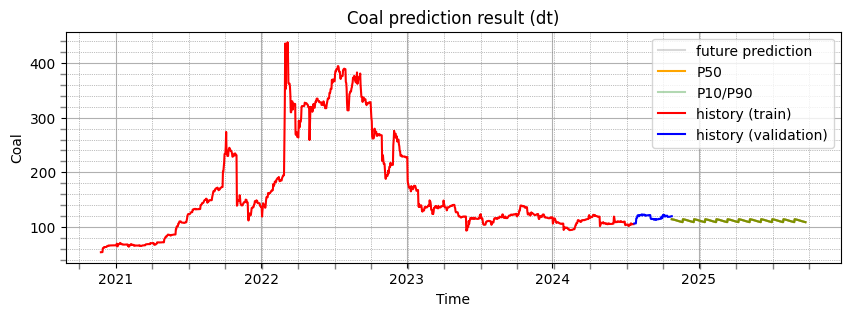

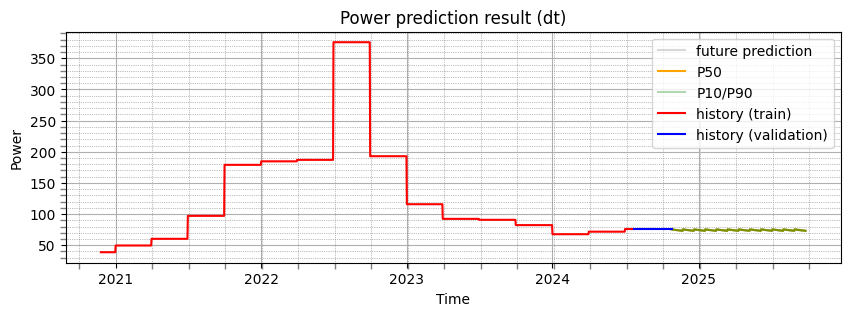

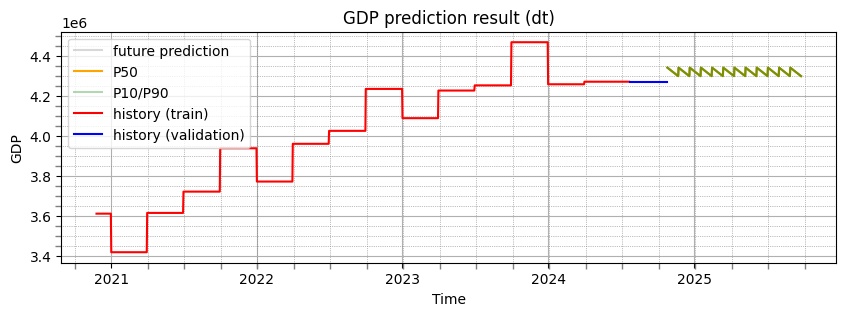

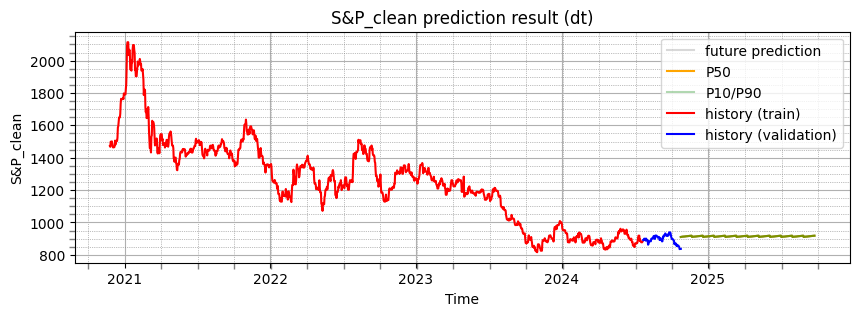

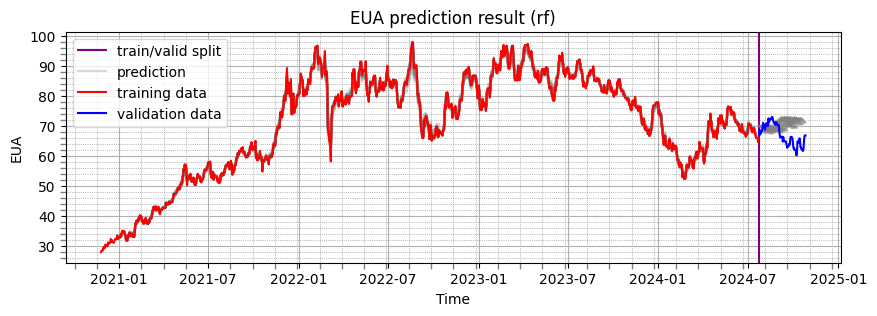

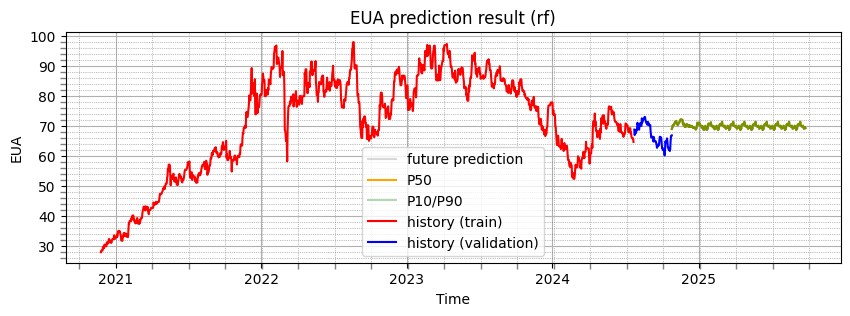

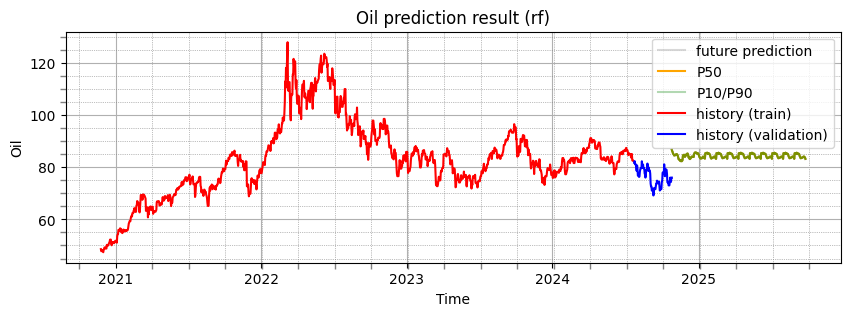

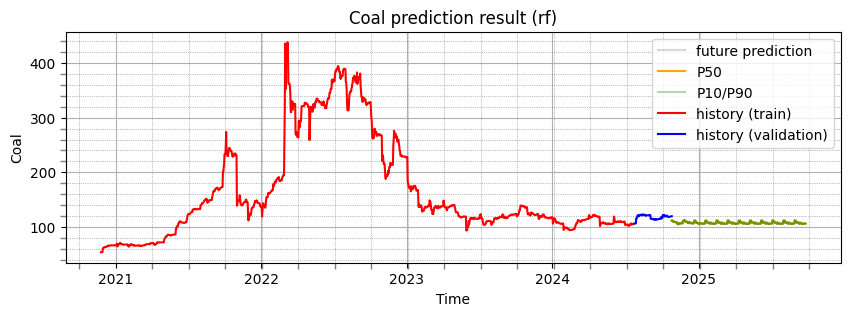

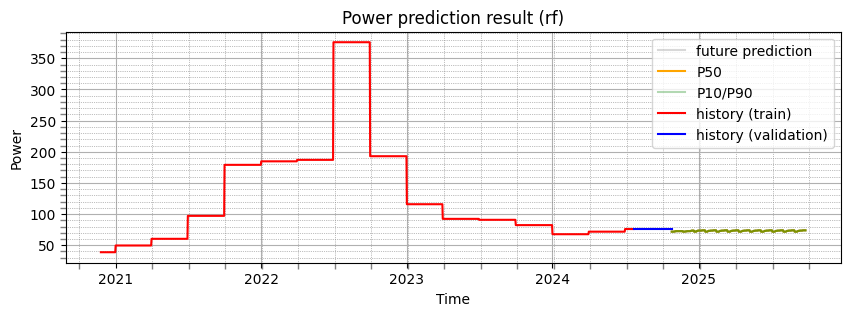

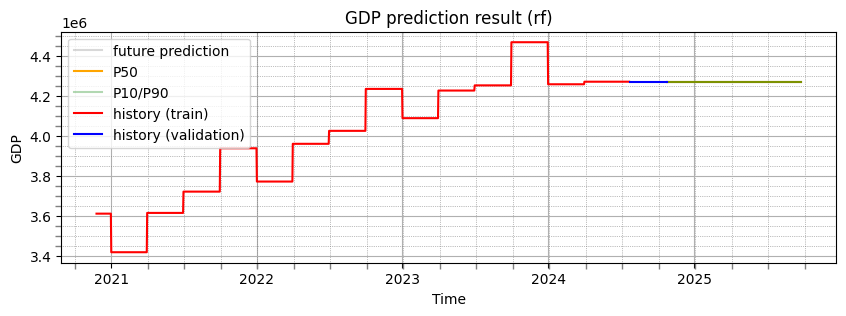

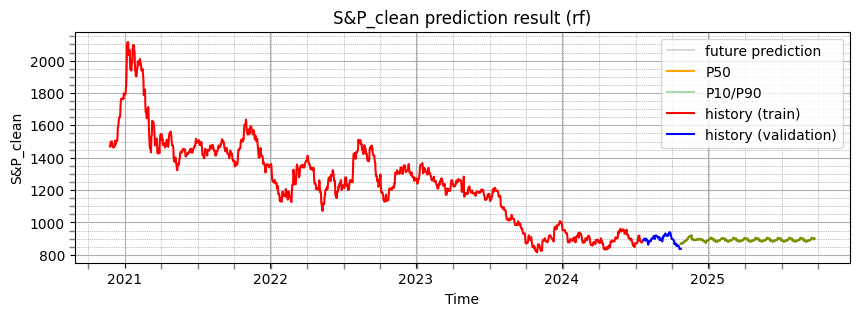

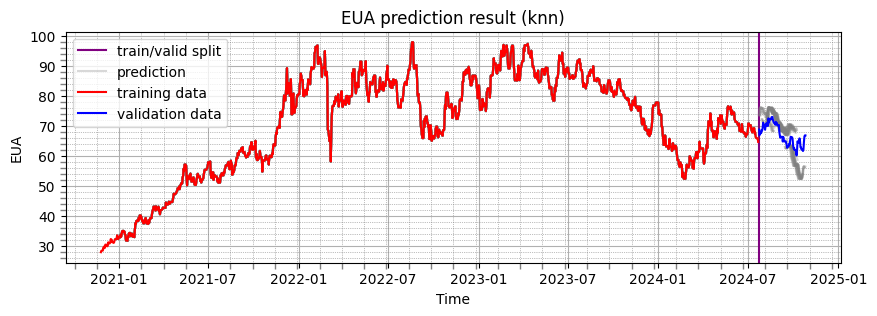

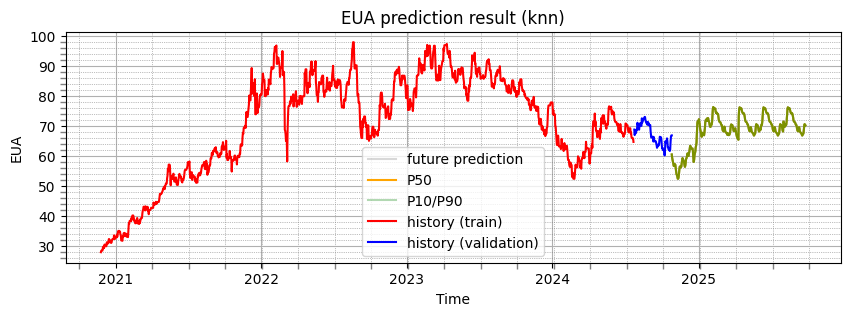

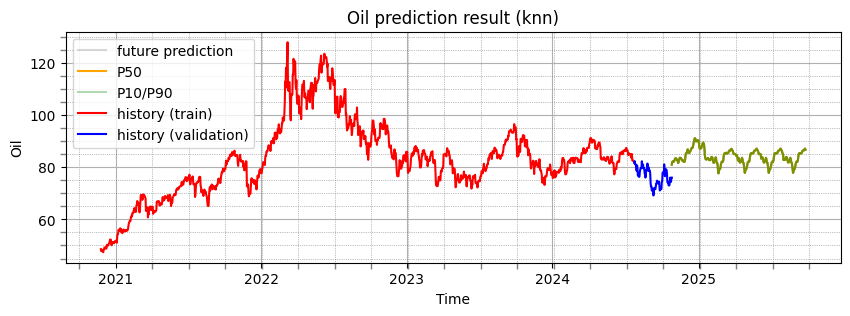

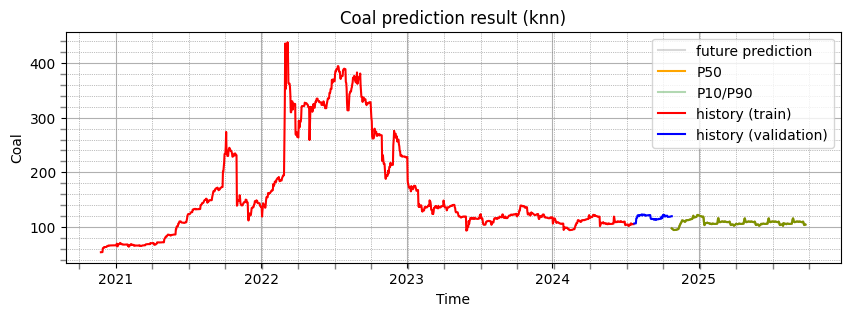

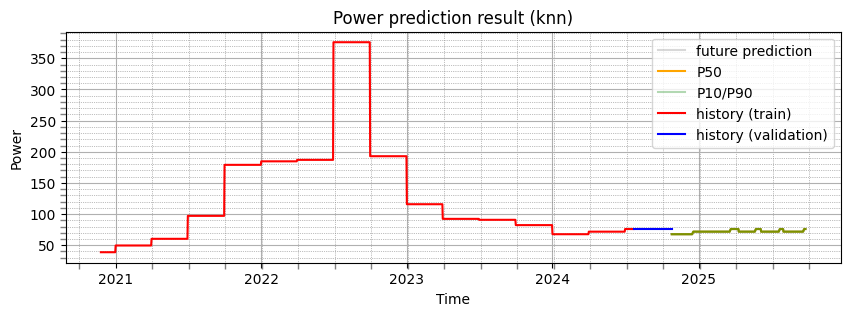

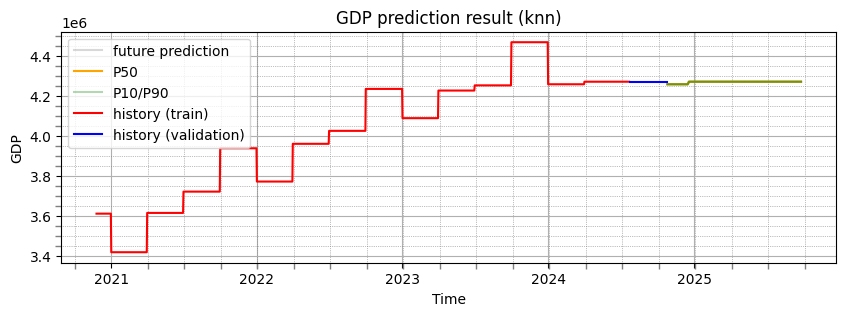

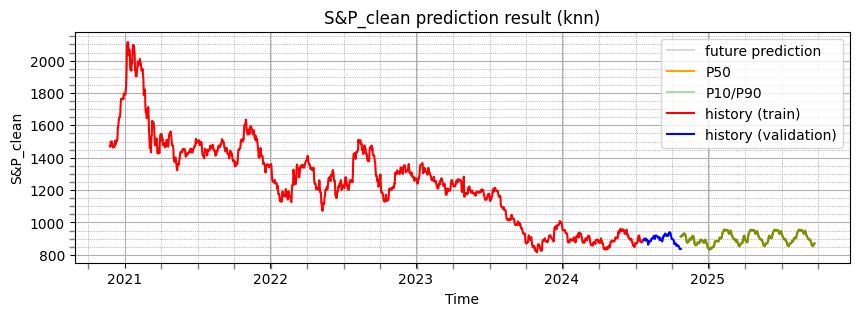

In [5]:
for model_name in models.keys():
    with open(f'best_mutistep_{model_name}_model.skl', 'rb') as f :
        model = pickle.load(f)
    # prediction for train/validation data
    y_train_pred = model.predict(X_train)
    y_test_pred =  model.predict(X_test)

    y_test_preds = []
    for i in range(10):
        y_test_preds.append(model.predict(X_test))
        
    from script.post_processing import inverse_scaler_of_all_var
    y_train_pred = inverse_scaler_of_all_var(y_train_pred, scaler).reshape(-1,sequence_length,len(predictors_lst))
    y_test_pred  = inverse_scaler_of_all_var(y_test_pred, scaler).reshape(-1,sequence_length,len(predictors_lst))
    y_test_preds = [i.reshape(-1,sequence_length,len(predictors_lst)) for i in inverse_scaler_of_all_var(y_test_preds, scaler)]
    y_train_true = inverse_scaler_of_all_var(y_train, scaler).reshape(-1,sequence_length,len(predictors_lst))
    y_test_true  = inverse_scaler_of_all_var(y_test, scaler).reshape(-1,sequence_length,len(predictors_lst))

    # define start of train date and valid/train split date
    train_start_date =  df_all['Date'][0] + pd.to_timedelta(28, unit = 'day')
    train_test_split_date = pd.to_datetime(test_date)

    # from script.save_permformance import save_perform
    # save_perform(model_name, y_train_true, y_train_pred, y_test_true, y_test_pred)
    # visuals of train/validation data prediction (single prediction)
    from script.post_processing import visual_train_n_valid_data_performance
    visual_train_n_valid_data_performance(y_train_pred,y_test_pred, 
                                        train_start_date, train_test_split_date, df_all,
                                        figsize = (10,3),
                                        decoration = {'xlabel': 'Time', 
                                                        'ylabel':'EUA', 
                                                        'title':f'EUA prediction result ({model_name})',
                                                        'grid':'on'})

    # 2. add recursive scheme
    from script.post_processing import resursive_furture_prediction_in_sklearn
    future_price_ensemble, future_time = resursive_furture_prediction_in_sklearn(model, 
                                                                                y_test[-1],
                                                                                train_test_split_date = df_all['Date'].max(),
                                                                                num_of_ensemble = 1,
                                                                                scaler = scaler,
                                                                                df_all = df_all,
                                                                                flatten  = True)
    # from script.post_processing import visual_recursive_future_prediction_plotly
    # visual_recursive_future_prediction_plotly(future_time, future_price_ensemble,
    #                                     train_test_split_date,
    #                                     df_all,
                                            
    #                                         index_of_data= 0, # 0 is EUA price
    #                                         name_of_data = 'EUA',
    #                                         decoration = {'xlabel': 'Time', 
    #                                                         'ylabel':'EUA', 
    #                                                         'title':f'EUA prediction result ({model_name})',
    #                                                         'grid':'on'})
    from script.post_processing import visual_recursive_future_prediction
    for i, name in enumerate(['EUA','Oil', 'Coal','Power', 'GDP', 'S&P_clean',]):
        visual_recursive_future_prediction(future_time, future_price_ensemble,
                                        train_test_split_date,
                                        df_all,
                                            figsize = (10,3),
                                            index_of_data= i, # 0 is EUA price
                                            name_of_data = name,
                                            decoration = {'xlabel': 'Time', 
                                                            'ylabel':name, 
                                                            'title':f'{name} prediction result ({model_name})',
                                                            'grid':'on'})
                                            